In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [3]:
import os
print(f"Current working directory: {os.getcwd()}")
print(f"Files in directory: {os.listdir()}")

Current working directory: c:\Users\timoz\Documents\GitHub\2203235_Capstone
Files in directory: ['.git', '.gitattributes', 'best_model.keras', 'best_model.pth', 'best_model.weights.h5', 'cnn-lstm-Baseline.ipynb', 'cnn-lstm-Best.ipynb', 'cnn-lstm-ver2.ipynb', 'cnn-lstm-ver3.ipynb', 'CNN_LSTM', 'Datasets', 'Data_collection.py', 'foundation.ipynb', 'foundation_model.keras', 'helper_functions.ipynb', 'improved_cnn_lstm.ipynb', 'improved_model.h5', 'MDB.csv', 'MDB_uncleaned.csv', 'meta.csv', 'model_comparison', 'prophet_lstm.ipynb', 'README.md', 'test.ipynb', 'test_foundation_on_new_data.ipynb', 'transformer-lstm-Baseline.ipynb', 'transformer-lstm-Best.ipynb', 'transformer-lstm-ver2.ipynb', 'transformer-lstm-Ver3.ipynb', 'transformer-lstm.ipynb', 'Transformer_lstm', 'xgboost-lstm-Baseline.ipynb', 'xgboost-lstm.ipynb', 'xgboost-lstmBest.ipynb', 'xgboost-lstmVer2.ipynb', 'xgboost-lstmVer3.ipynb', 'xgboost_lstm']


In [6]:
def plot_model_comparison(metrics_df):
    metrics = ['RMSE', 'MAE', 'MAPE', 'R2']
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        # Create pivot table for heatmap
        pivot_table = metrics_df.pivot(index='Model', columns='Stock', values=metric)
        
        # Choose colormap based on metric
        # For R2, higher is better (use YlOrRd_r)
        # For others, lower is better (use YlOrRd)
        cmap = 'YlOrRd_r' if metric == 'R2' else 'YlOrRd'
        
        # Create heatmap
        sns.heatmap(pivot_table, annot=True, fmt='.3f', ax=axes[idx], 
                    cmap=cmap, center=None)
        
        axes[idx].set_title(f'{metric} Comparison Across Models and Stocks', 
                          fontsize=12, fontweight='bold', pad=20)
        axes[idx].set_xlabel('Stocks', fontsize=10)
        axes[idx].set_ylabel('Models', fontsize=10)
        
        # Rotate x-axis labels for better readability
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    
    plt.suptitle('Comprehensive Model Performance Comparison', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print best model for each metric
    print("\nBest Performing Models:")
    for metric in metrics:
        if metric == 'R2':
            best_idx = metrics_df[metric].idxmax()
        else:
            best_idx = metrics_df[metric].idxmin()
            
        best_row = metrics_df.iloc[best_idx]
        print(f"\n{metric}:")
        print(f"Best Model: {best_row['Model']}")
        print(f"Stock: {best_row['Stock']}")
        print(f"Value: {best_row[metric]:.3f}")

Found metric files:
c:\Users\timoz\Documents\GitHub\2203235_Capstone\CNN_LSTM\cnn-lstm-improved\metrics_CNN-LSTM-Improved_META.csv
c:\Users\timoz\Documents\GitHub\2203235_Capstone\CNN_LSTM\cnn-lstm-improved\metrics_CNN-LSTM-Improved_MSFT.csv
c:\Users\timoz\Documents\GitHub\2203235_Capstone\CNN_LSTM\cnn-lstm-improved\metrics_CNN-LSTM-Improved_NFLX.csv
c:\Users\timoz\Documents\GitHub\2203235_Capstone\CNN_LSTM\cnn-lstm-improved\metrics_CNN-LSTM-Improved_NVDA.csv
c:\Users\timoz\Documents\GitHub\2203235_Capstone\CNN_LSTM\cnn-lstm-improved\metrics_CNN-LSTM-Improved_ORCL.csv
c:\Users\timoz\Documents\GitHub\2203235_Capstone\CNN_LSTM\cnn-lstm-original\metrics_CNN-LSTM-Baseline_META.csv
c:\Users\timoz\Documents\GitHub\2203235_Capstone\CNN_LSTM\cnn-lstm-original\metrics_CNN-LSTM-Baseline_MSFT.csv
c:\Users\timoz\Documents\GitHub\2203235_Capstone\CNN_LSTM\cnn-lstm-original\metrics_CNN-LSTM-Baseline_NFLX.csv
c:\Users\timoz\Documents\GitHub\2203235_Capstone\CNN_LSTM\cnn-lstm-original\metrics_CNN-LSTM

ValueError: Index contains duplicate entries, cannot reshape

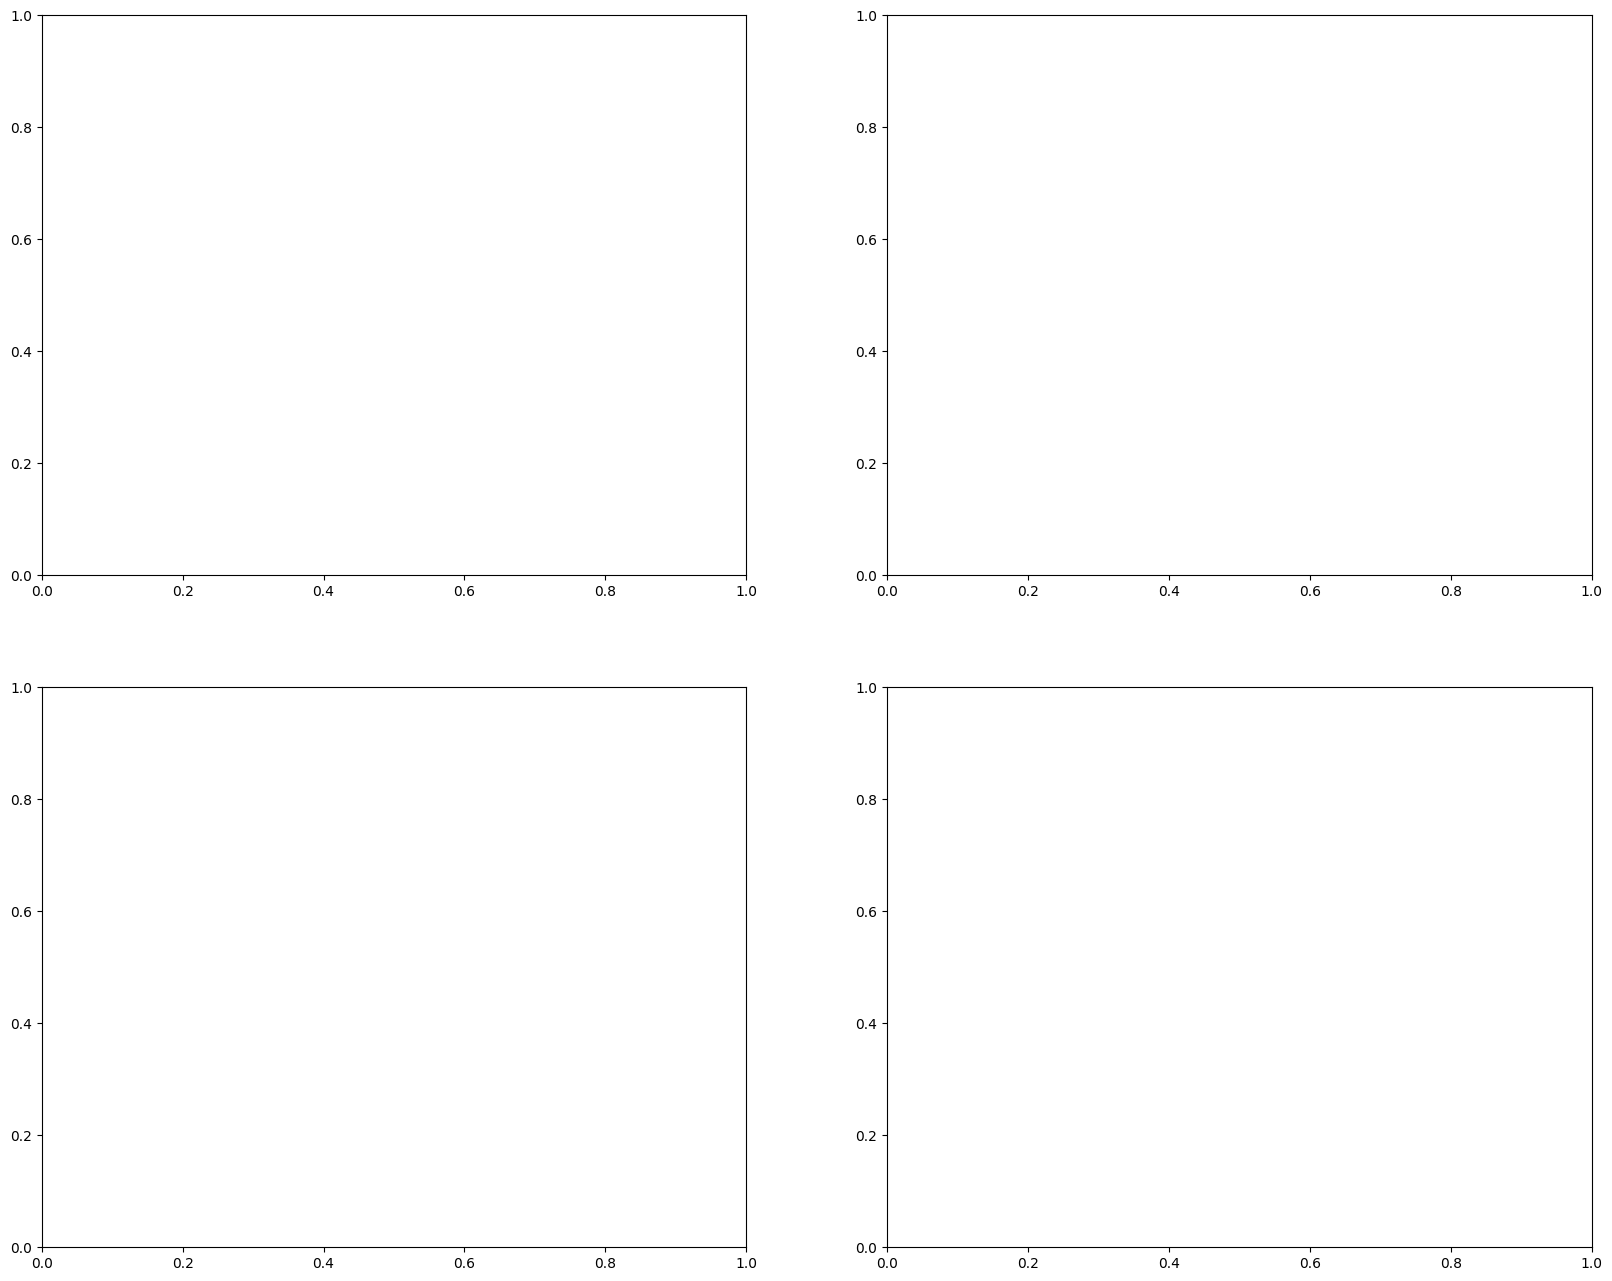

In [7]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths to metrics files
base_path = os.getcwd()
paths = [
    os.path.join(base_path, "CNN_LSTM", "cnn-lstm-improved"),
    os.path.join(base_path, "CNN_LSTM", "cnn-lstm-original"),
    os.path.join(base_path, "Transformer_lstm"),
    os.path.join(base_path, "xgboost_lstm")
]

# Collect all metrics files
all_files = []
for path in paths:
    files = glob.glob(os.path.join(path, 'metrics_*.csv'))
    all_files.extend(files)

# Print found files for debugging
print("Found metric files:")
for f in all_files:
    print(f)

# Read and concatenate all metrics files
if len(all_files) > 0:
    all_metrics = pd.concat([pd.read_csv(f) for f in all_files])
    plot_model_comparison(all_metrics)
else:
    print("\nNo metrics files found. Please check that:")
    print("1. The CSV files exist in the specified directories")
    print("2. The files follow the naming pattern 'metrics_*.csv'")
    for path in paths:
        print(f"3. Checking directory: {path}")
        if os.path.exists(path):
            print(f"   Directory exists. Contents: {os.listdir(path)}")
        else:
            print(f"   Directory does not exist!")

In [ ]:


# Read all metrics CSV files
all_files = glob.glob('metrics_*.csv')
all_metrics = pd.concat([pd.read_csv(f) for f in all_files])

def plot_model_comparison(metrics_df):
    metrics = ['RMSE', 'MAE', 'MAPE', 'R2']
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        # Create pivot table for heatmap
        pivot_table = metrics_df.pivot(index='Model', columns='Stock', values=metric)
        
        # Choose colormap based on metric
        # For R2, higher is better (use YlOrRd_r)
        # For others, lower is better (use YlOrRd)
        cmap = 'YlOrRd_r' if metric == 'R2' else 'YlOrRd'
        
        # Create heatmap
        sns.heatmap(pivot_table, annot=True, fmt='.3f', ax=axes[idx], 
                    cmap=cmap, center=None)
        
        axes[idx].set_title(f'{metric} Comparison Across Models and Stocks', 
                          fontsize=12, fontweight='bold', pad=20)
        axes[idx].set_xlabel('Stocks', fontsize=10)
        axes[idx].set_ylabel('Models', fontsize=10)
        
        # Rotate x-axis labels for better readability
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    
    plt.suptitle('Comprehensive Model Performance Comparison', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print best model for each metric
    print("\nBest Performing Models:")
    for metric in metrics:
        if metric == 'R2':
            best_idx = metrics_df[metric].idxmax()
        else:
            best_idx = metrics_df[metric].idxmin()
            
        best_row = metrics_df.iloc[best_idx]
        print(f"\n{metric}:")
        print(f"Best Model: {best_row['Model']}")
        print(f"Stock: {best_row['Stock']}")
        print(f"Value: {best_row[metric]:.3f}")

# Create visualization
plot_model_comparison(all_metrics)

ValueError: No objects to concatenate